## **Simulando o Feixe**

Esse trabalho tem como objetivo simular o comportamento de um feixe de elétrons em acelerador linear, bem como a sua correção utilizando eletroímãs de quadrupolo.



In [140]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

# %matplotlib widget

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12 
})

Equações principais:

$$
\vec{F} = m \cdot \vec{a} = \frac{d\vec{p}}{dt}
$$

$$
\gamma = \sqrt{1 + \left(\frac{|\vec{v}|}{c} \right)^2} = \sqrt{1 + \left(\frac{|\vec{p}|}{m_0 c}\right)^2}
$$

$$
\vec{v} = \frac{\vec{v}}{\gamma} = \frac{\vec{p}}{m_0 \gamma} \approx c
$$

<!-- $$
\vec{v} = v_x \hat{i} + v_y \hat{j} + v_z \hat{k} \rightarrow |\vec{v}| = \sqrt{v_x^2 + v_y^2 + v_z^2} \approx c
$$ -->

$$
\vec{B} = B_x \hat{i} + B_y \hat{j} + B_z \hat{k}
$$

$$
\vec{F}^{N+1} = \vec{F}^{N} + \vec{f}_{ext} \cdot \Delta t = \vec{F}^{N} + q \cdot \vec{v} \times \vec{B} \cdot \Delta t
$$

In [141]:
np.random.seed(404)

config = {
    "V_LUZ": 2.99792458e8, # m\s
    "MASSA_E": 9.1093837e-31, # kg
    "CARGA_E": 1.60217663e-19, # C
    "HEIGHT": 100,
    "WIDTH": 100,
}

parametros = {
    "vx0": 0.0,
    "vy0": 0.0,
    "vz0": 0.999999 * config["V_LUZ"],
    "x0": 0.0,
    "y0": 0.0,
    "z0": 0.0,
    "forca": [0, 0, 0],
    "int_ruido": 1e-7,
    "dt": 1e-13,
    "dist": 1.5,
}       

In [142]:
class FeixeEletron():
    def __init__(self, parametros, config):
        self.c = config["V_LUZ"]
        self.m_e = config["MASSA_E"]
        self.dt = parametros["dt"]
        self.int_ruido = parametros["int_ruido"]

        self.forca = np.array(parametros["forca"], dtype=float)
        self.pos0 = np.array([parametros["x0"], parametros["y0"], parametros["z0"]], dtype=float)
        self.vel0 = np.array([parametros["vx0"], parametros["vy0"], parametros["vz0"]], dtype=float)

        v0_mag = np.linalg.norm(self.vel0)
        self.gamma0 = 1.0 / np.sqrt(1.0 - (v0_mag/self.c)**2)
        self.momento0 = self.m_e * self.vel0 * self.gamma0

    def momento_para_velocidade(self, momento):
        momento_norm = np.linalg.norm(momento)
        gamma = np.sqrt(1 + ((momento_norm)/(self.m_e * self.c))**2)

        velocidade = momento / (gamma * self.m_e)

        return velocidade
    
    def aplicar_ruido(self, vetor, intensidade_max):
        # theta_x, theta_y, theta_z = np.random.uniform(-intensidade_max, intensidade_max, 3)
        theta_x, theta_y, theta_z = np.random.normal(0, (1e-5)**2, 3)
        
        Rx = np.array([[1, 0, 0], [0, np.cos(theta_x), -np.sin(theta_x)], [0, np.sin(theta_x), np.cos(theta_x)]])
        
        Ry = np.array([[np.cos(theta_y), 0, np.sin(theta_y)], [0, 1, 0], [-np.sin(theta_y), 0, np.cos(theta_y)]])
        
        vetor_rotacionado = Ry @ (Rx @ vetor)
        
        return vetor_rotacionado

    def runge_kutta(self, n_times):
        self.pos = np.zeros((n_times + 1, 3))
        self.vel = np.zeros((n_times + 1, 3))
        self.momentos = np.zeros((n_times + 1, 3))
        self.t = np.zeros(n_times + 1)

        self.pos[0] = self.pos0
        self.vel[0] = self.vel0

        momento_atual = self.momento0
        pos_atual = self.pos0
    
        for i in range(n_times):
            # k1
            momento_k1 = momento_atual
            v_k1 = self.momento_para_velocidade(momento_k1)       
            forca_k1 = self.forca

            # k2
            momento_k2 = momento_atual + 0.5 * self.dt * forca_k1 
            v_k2 = self.momento_para_velocidade(momento_k2)
            forca_k2 = self.forca

            # k3
            momento_k3 = momento_atual + 0.5 * self.dt * forca_k1
            v_k3 = self.momento_para_velocidade(momento_k3)
            forca_k3 = self.forca

            # k4
            momento_k4 = momento_atual + self.dt * forca_k3
            v_k4 = self.momento_para_velocidade(momento_k4)
            forca_k4 = self.forca

            # somando
            momento_atual += (self.dt / 6) * (forca_k1 + 2*forca_k2 + 2*forca_k3 + forca_k4)
            pos_atual += (self.dt / 6) * (v_k1 + 2*v_k2 + 2*v_k3 + v_k4)

            momento_atual = self.aplicar_ruido(momento_atual, self.int_ruido)
            
            self.momentos[i+1] = momento_atual
            self.vel[i+1] = self.momento_para_velocidade(momento_atual)
            self.pos[i+1] = pos_atual
            self.t[i+1] = (i+1) * self.dt  

distancia = parametros["dist"]
segundos = distancia / config["V_LUZ"]
N_PASSOS = int(segundos / parametros["dt"])

eletron = FeixeEletron(parametros, config)
eletron.runge_kutta(N_PASSOS)
eletron.vel[0:10]


array([[ 0.00000000e+00,  0.00000000e+00,  2.99792158e+08],
       [ 4.00960516e-02,  3.54561455e-02,  2.99792158e+08],
       [ 3.38214218e-02,  1.87684218e-02,  2.99792158e+08],
       [ 3.25197560e-02, -1.82539145e-02,  2.99792158e+08],
       [ 7.28101547e-02, -5.42497182e-02,  2.99792158e+08],
       [ 1.22749505e-01, -8.53081168e-02,  2.99792158e+08],
       [ 1.34575730e-01, -1.17296226e-01,  2.99792158e+08],
       [ 1.05660891e-01, -7.67252187e-02,  2.99792158e+08],
       [ 7.54945613e-02, -8.63529691e-02,  2.99792158e+08],
       [ 8.09462607e-02, -8.72620500e-02,  2.99792158e+08]])

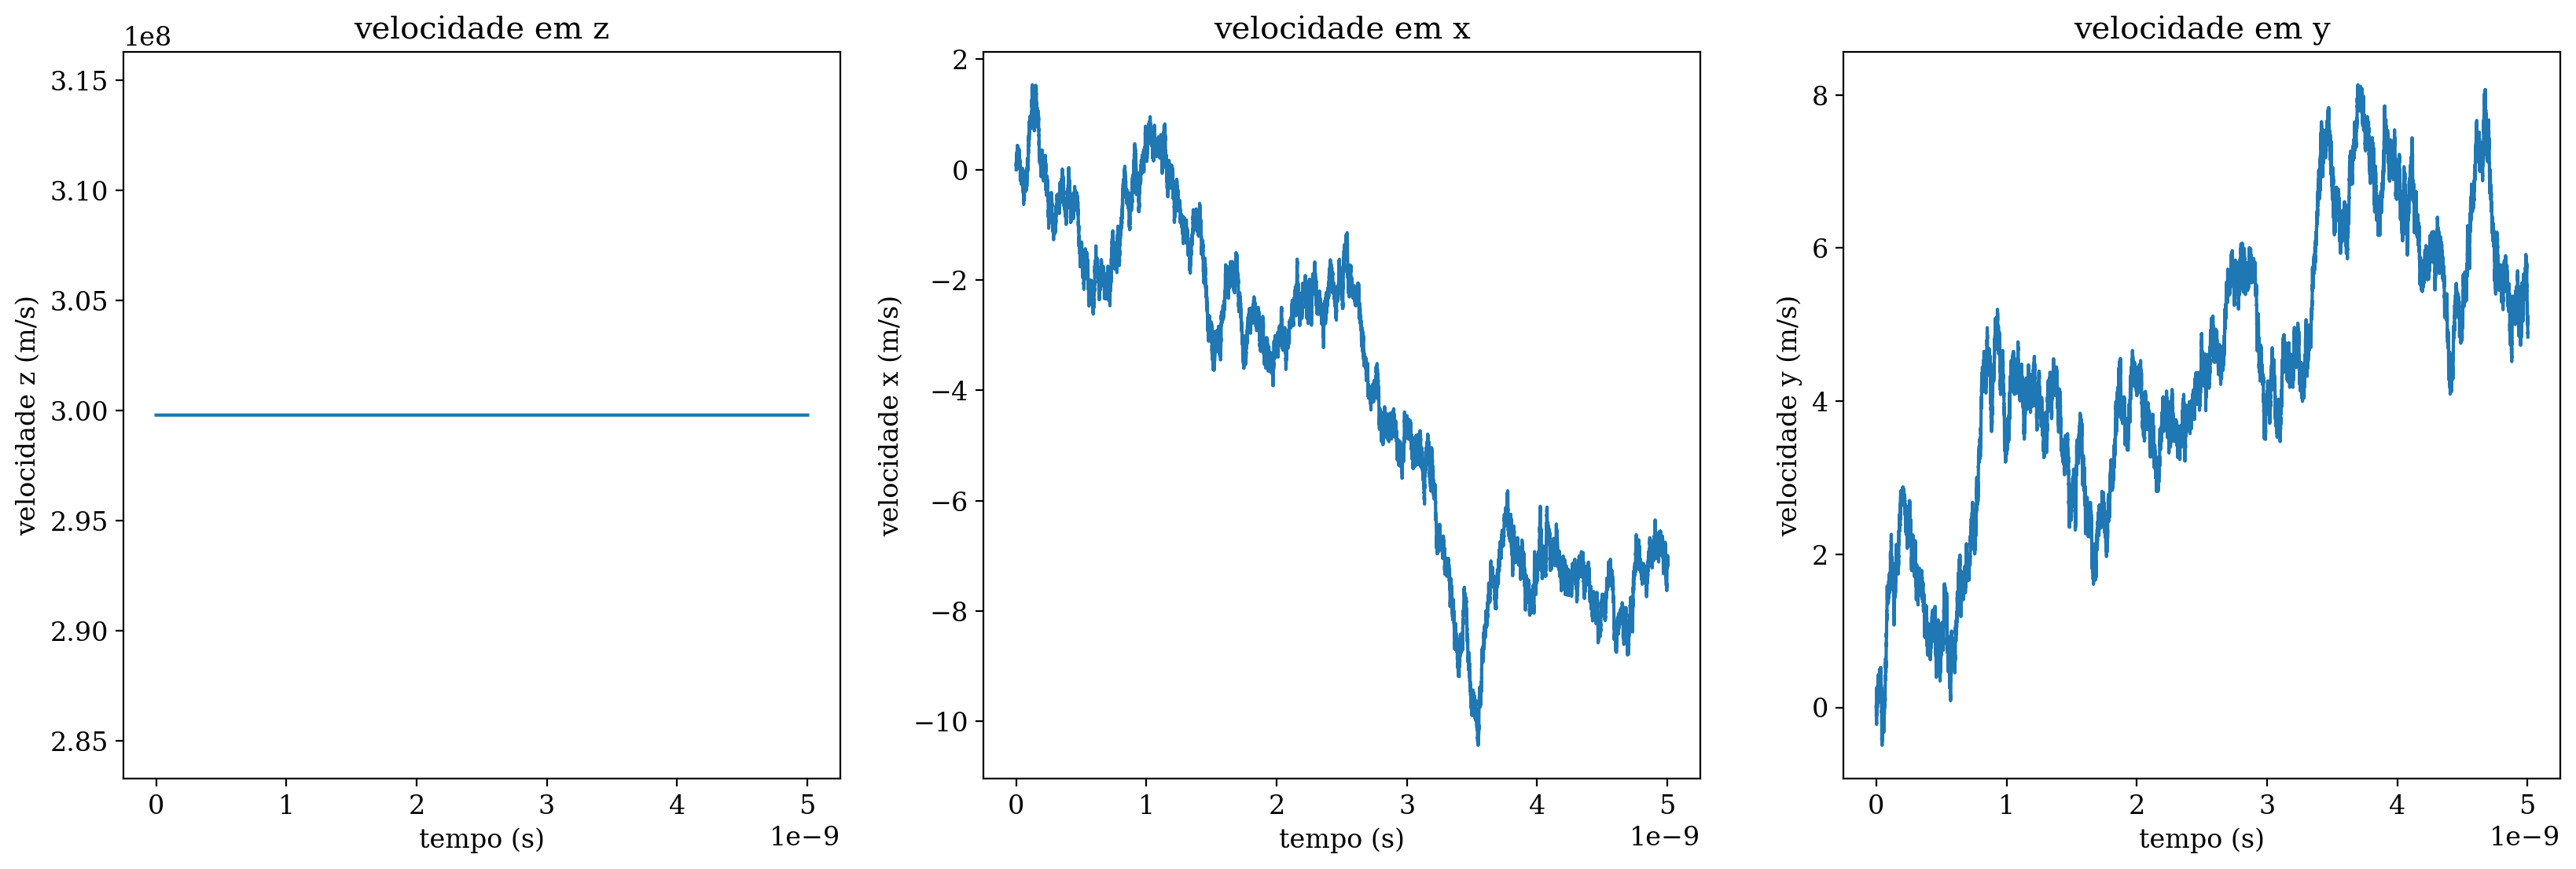

In [143]:
tempo = eletron.t
velocidade_x = eletron.vel[:, 0]
velocidade_y = eletron.vel[:, 1]
velocidade_z = eletron.vel[:, 2]
posicao = eletron.pos[:, 2]

fig = plt.figure(figsize=(20, 6), dpi=200)
gs = gridspec.GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(tempo, velocidade_z)
ax1.set_ylabel("velocidade z (m/s)")
ax1.set_xlabel("tempo (s)")
ax1.set_title("velocidade em z")

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(tempo, velocidade_x)
ax3.set_ylabel("velocidade x (m/s)")
ax3.set_xlabel("tempo (s)")
ax3.set_title("velocidade em x")

ax4 = fig.add_subplot(gs[0, 2])
ax4.plot(tempo, velocidade_y)
ax4.set_ylabel("velocidade y (m/s)")
ax4.set_xlabel("tempo (s)")
ax4.set_title("velocidade em y")

# ax2 = fig.add_subplot(gs[1, 1])
# ax2.plot(tempo, posicao)
# ax2.set_ylabel("posição (m)")
# ax2.set_xlabel("tempo (s)")
# ax2.set_title("posição")


plt.show()


<!-- - Delay: Olhar para a posição do elétron $N$ passos atrás no tempo. (~150 nanosegundos)

- Controle: Com base no desvio detectado no passado, ajustamos a corrente (o Gradiente $G$) do eletroímã.

- Força de Lorentz: Aplicamos a força magnética baseada nesse gradiente na posição atual do elétron. O campo de um quadripolo ideal é geralmente $\vec{B} = G \cdot (y \hat{i} + x \hat{j}, 0)$. -->

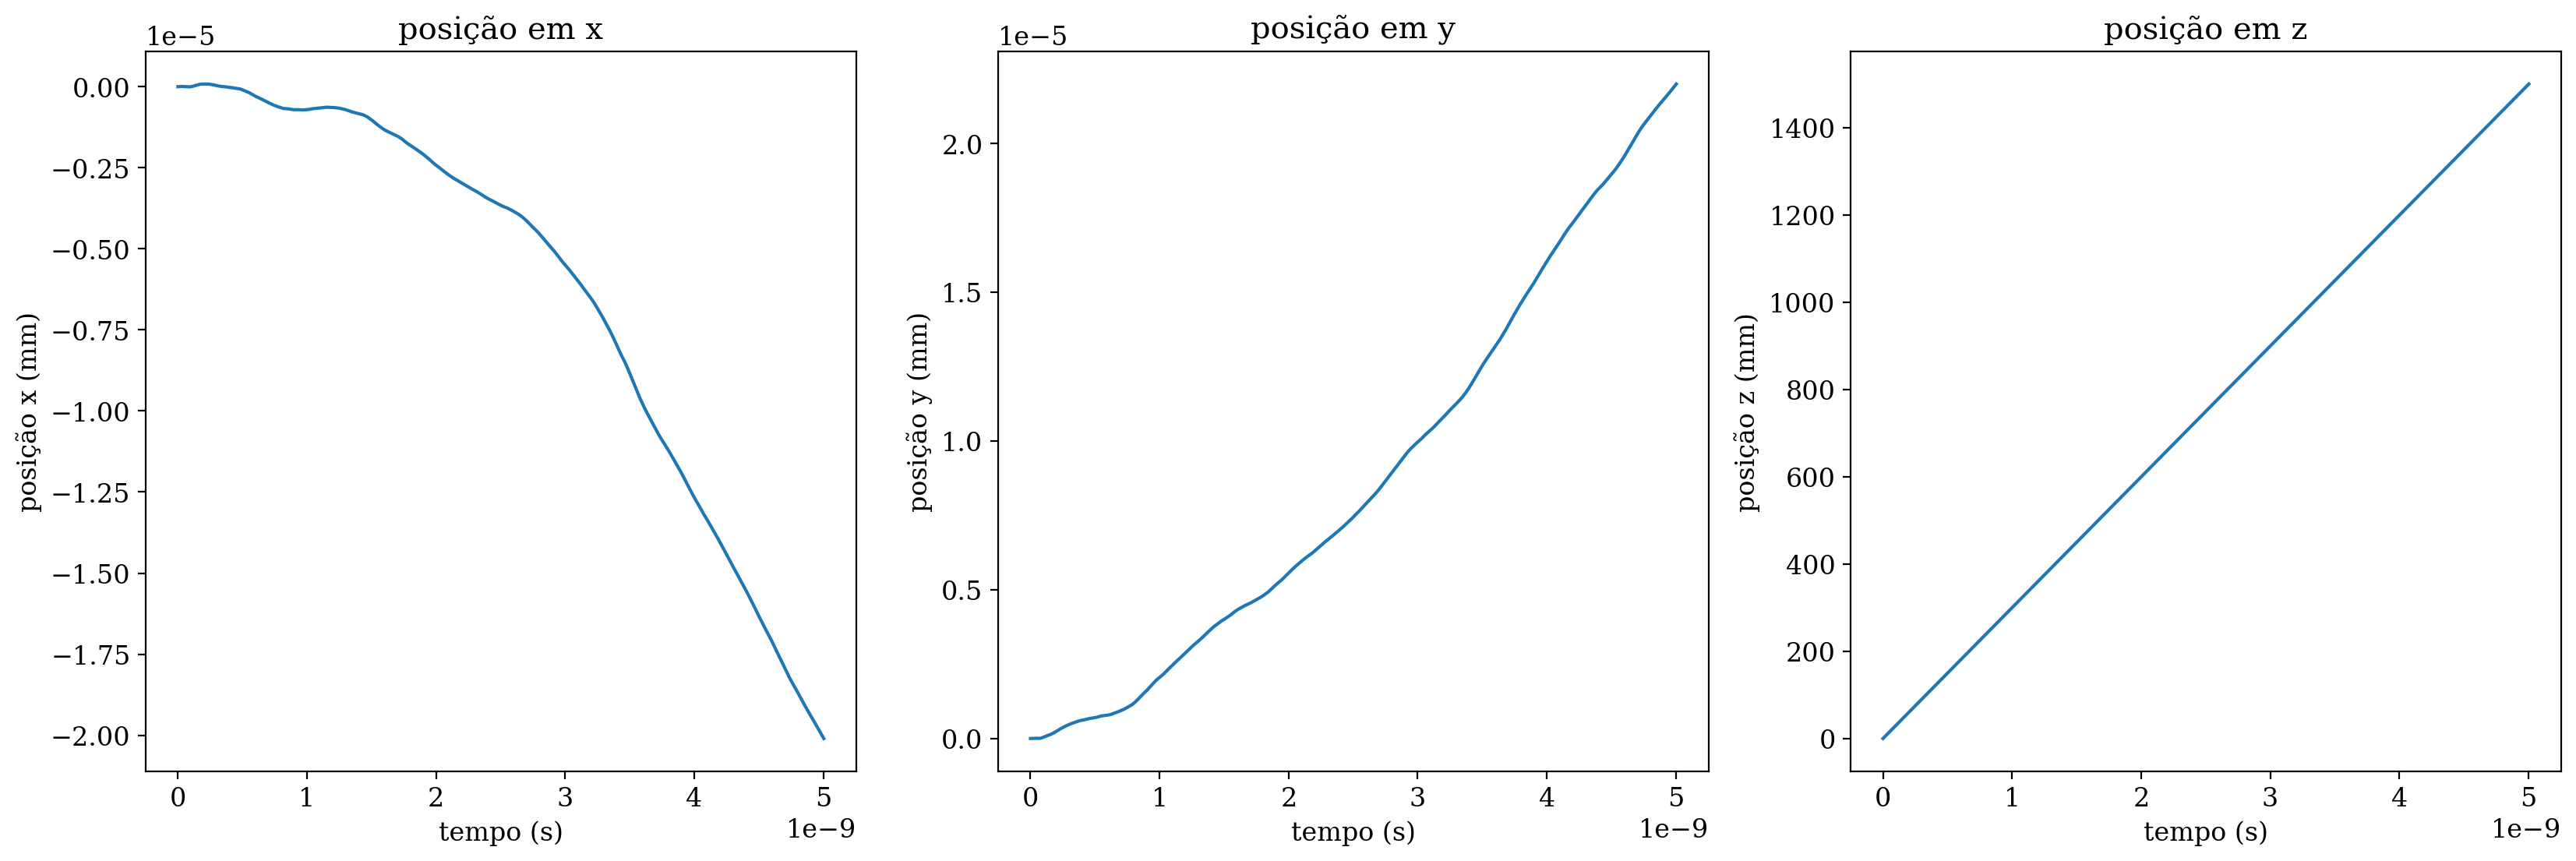

In [144]:
tempo = eletron.t
velocidade_x = eletron.vel[:, 0]
velocidade_y = eletron.vel[:, 1]
velocidade_z = eletron.vel[:, 2]
posicao_x = eletron.pos[:, 0]
posicao_y = eletron.pos[:, 1]
posicao_z = eletron.pos[:,   2]

fig = plt.figure(figsize=(20, 6), dpi=200)
gs = gridspec.GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(tempo, posicao_x * 1000)
ax1.set_ylabel("posição x (mm)")
ax1.set_xlabel("tempo (s)")
ax1.set_title("posição em x")

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(tempo, posicao_y * 1000)
ax3.set_ylabel("posição y (mm)")
ax3.set_xlabel("tempo (s)")
ax3.set_title("posição em y")

ax4 = fig.add_subplot(gs[0, 2])
ax4.plot(tempo, posicao_z * 1000)
ax4.set_ylabel("posição z (mm)")
ax4.set_xlabel("tempo (s)")
ax4.set_title("posição em z")

# ax2 = fig.add_subplot(gs[1, 1])
# ax2.plot(tempo, posicao)
# ax2.set_ylabel("posição (m)")
# ax2.set_xlabel("tempo (s)")
# ax2.set_title("posição")

plt.show()